# Download Data

In [ ]:
!gdown 1AVwOqpTwzClFShhlEMl486uuc0YULWlO
!gdown 1cecqak_khzMWkvmJ7HnMB-KNSjCOzaQv
!gdown 1bCcdyV0bj5C0t9f8CrX3u_La2HeF5qdD
!gdown 1_256TK65P5pvpjZARYQqTScauq0LAvzE

In [ ]:
!pip install datasets evaluate

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from datasets import Dataset, DatasetDict, Features, ClassLabel, Array3D

# Read Data

In [3]:
train_X = np.load('train_images.npy')
train_y = np.load('train_labels.npy')
test_X = np.load('test_images.npy')
test_y = np.load('test_labels.npy')

In [4]:
print("Train Images", train_X.shape)
print("Train Labels", train_y.shape)

Train Images (28709, 48, 48, 1)
Train Labels (28709, 7)


In [5]:
labels = ["angry", "disgusted", "fearful", "happy", "neutral", "sad", "surprised"]

## Visualize Images

In [6]:
def show(idx):
    plt.figure(figsize=(10, 6))
    plt.imshow(train_X[idx], cmap="gray")
    plt.title(labels[np.argmax(train_y[idx])])
    plt.axis("off")
    plt.show()

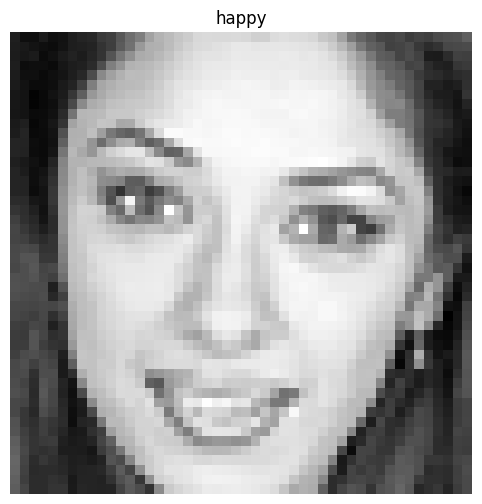

In [7]:
show(np.random.randint(len(train_X)))

## Convert to HuggingFace dataset

In [8]:
train_data = [{"image": img, "label": np.argmax(label)} for img, label in zip(train_X, train_y)]
test_data = [{"image": img, "label": np.argmax(label)} for img, label in zip(test_X, test_y)]

train_dataset = Dataset.from_list(train_data)
test_dataset = Dataset.from_list(test_data)

features = Features({
    "image": Array3D(dtype="float32", shape=(48, 48, 1)),
    "label": ClassLabel(num_classes=len(labels), names=labels),
})

train_dataset = train_dataset.cast(features)
test_dataset = test_dataset.cast(features)

dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset,
})

print(dataset)

Casting the dataset:   0%|          | 0/28709 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/7178 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 28709
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 7178
    })
})


## Save Dataset

In [9]:
dataset.save_to_disk("./FER_dataset")

Saving the dataset (0/2 shards):   0%|          | 0/28709 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7178 [00:00<?, ? examples/s]

# Vision Transformer

In [1]:
from transformers import ViTForImageClassification, ViTImageProcessor
from transformers import Trainer, TrainingArguments
from evaluate import load as load_metric
from datasets import Dataset, DatasetDict
import numpy as np
import torch

## Preprocess Data

In [2]:
dataset = DatasetDict.load_from_disk('./FER_dataset')
labels = ["angry", "disgusted", "fearful", "happy", "neutral", "sad", "surprised"]

In [3]:
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

def preprocess_data(examples):
    images = [np.stack([np.array(img).squeeze(-1)] * 3, axis=-1) for img in examples["image"]]
    inputs = feature_extractor(images=images, return_tensors="pt", do_rescale=False, )
    inputs["label"] = examples["label"]
    return inputs

In [4]:
dataset = dataset.map(preprocess_data, batched=True)

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'pixel_values'],
        num_rows: 28709
    })
    test: Dataset({
        features: ['image', 'label', 'pixel_values'],
        num_rows: 7178
    })
})

## Training

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(labels),
).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
accuracy_metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./vit-finetuning",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
)

train_dataset = dataset["train"].with_format("torch")
test_dataset = dataset["test"].with_format("torch")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [9]:
trainer.train()
trainer.save_model("./vit-base-patch16-224-fer")

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.945050,0.660072
2,1.087300,0.883912,0.674422
3,0.756800,0.845430,0.700892
4,0.540600,0.880463,0.707161
5,0.355700,0.916989,0.703957


# Inference

In [10]:
from PIL import Image
import requests

In [11]:
labels = ["angry", "disgusted", "fearful", "happy", "neutral", "sad", "surprised"]

In [ ]:
url = 'https://media.licdn.com/dms/image/v2/D5635AQG4cQk_hcQ14A/profile-framedphoto-shrink_800_800/profile-framedphoto-shrink_800_800/0/1725817274557?e=1733374800&v=beta&t=_ERY0ZH14KhmH1v997jAypKhYwfAK6xTkeJcKqgk_eA'
image = Image.open(requests.get(url, stream=True).raw)
image

In [14]:
model = ViTForImageClassification.from_pretrained('./vit-base-patch16-224-fer')
inputs = feature_extractor(images=image, return_tensors="pt")


In [15]:
outputs = model(**inputs)

In [16]:
labels[outputs.logits.argmax()]

'happy'